https://www.kaggle.com/code/mohamedbhy/automatic-number-plate-recognition

In [ ]:
#kaggle datasets download -d aslanahmedov/number-plate-detection

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
! chmod 600 /content/kaggle.json

In [ ]:
! KAGGLE_CONFIG_DIR=/content/ kaggle datasets download -d aslanahmedov/number-plate-detection

 95% 390M/413M [00:04<00:00, 98.2MB/s]
100% 413M/413M [00:04<00:00, 105MB/s] 


In [ ]:
!pip install pytesseract

In [ ]:
import zipfile
from tqdm import tqdm

def extract_with_progress(zip_file, destination):
    with zipfile.ZipFile(zip_file, 'r') as zip_ref:
        total_size = sum(file.file_size for file in zip_ref.infolist())
        progress = 0
        for file in tqdm(zip_ref.infolist(), unit='B', unit_scale=True, desc='Extracting'):
            zip_ref.extract(file, destination)
            progress += file.file_size

if __name__ == "__main__":
    zip_file = '/content/number-plate-detection.zip'
    destination = '/home/'
    extract_with_progress(zip_file, destination)


Extracting: 100%|██████████| 456/456 [00:01<00:00, 320B/s]


In [ ]:
import os
import cv2
import numpy as np
import pandas as pd
import tensorflow as tf
import pytesseract as pt
import plotly.express as px
import matplotlib.pyplot as plt
import xml.etree.ElementTree as xet
from tensorflow.keras.applications import VGG16
from glob import glob
from skimage import io
from shutil import copy
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import TensorBoard
from sklearn.model_selection import train_test_split
#from tensorflow.keras.applications import InceptionResNetV2
from tensorflow.keras.layers import Dense, Dropout, Flatten, Input
from tensorflow.keras.preprocessing.image import load_img, img_to_array

In [ ]:
path = glob('/home/images/*.xml')
labels_dict = dict(filepath=[],xmin=[],xmax=[],ymin=[],ymax=[])
for filename in path:

    info = xet.parse(filename)
    root = info.getroot()
    member_object = root.find('object')
    labels_info = member_object.find('bndbox')
    xmin = int(labels_info.find('xmin').text)
    xmax = int(labels_info.find('xmax').text)
    ymin = int(labels_info.find('ymin').text)
    ymax = int(labels_info.find('ymax').text)

    labels_dict['filepath'].append(filename)
    labels_dict['xmin'].append(xmin)
    labels_dict['xmax'].append(xmax)
    labels_dict['ymin'].append(ymin)
    labels_dict['ymax'].append(ymax)

In [ ]:
df = pd.DataFrame(labels_dict)
df.to_csv('labels.csv',index=False)
df.head()

,filepath,xmin,xmax,ymin,ymax
0,/home/images/N215.xml,85,258,390,446
1,/home/images/N124.xml,165,328,276,324
2,/home/images/N92.xml,113,420,209,260
3,/home/images/N130.xml,419,513,173,213
4,/home/images/N240.xml,164,285,99,137


In [ ]:
filename = df['filepath'][0]
def getFilename(filename):
    filename_image = xet.parse(filename).getroot().find('filename').text
    filepath_image = os.path.join('/home/images/',filename_image)
    return filepath_image
getFilename(filename)

'/home/images/N215.jpeg'

In [ ]:
image_path = list(df['filepath'].apply(getFilename))
image_path[:10]#random check

['/home/images/N215.jpeg',
 '/home/images/N124.jpeg',
 '/home/images/N92.jpeg',
 '/home/images/N130.jpeg',
 '/home/images/N240.jpeg',
 '/home/images/N175.jpeg',
 '/home/images/N82.jpeg',
 '/home/images/N227.jpeg',
 '/home/images/N64.jpeg',
 '/home/images/N16.jpeg']

In [ ]:
file_path = image_path[87] #path of our image N2.jpeg
img = cv2.imread(file_path) #read the image
# xmin-1804/ymin-1734/xmax-2493/ymax-1882
img = io.imread(file_path) #Read the image
fig = px.imshow(img)
fig.update_layout(width=600, height=500, margin=dict(l=10, r=10, b=10, t=10),xaxis_title='Figure 8 - N2.jpeg with bounding box')
fig.add_shape(type='rect',x0=1804, x1=2493, y0=1734, y1=1882, xref='x', yref='y',line_color='cyan')

In [ ]:
#Targeting all our values in array selecting all columns
labels = df.iloc[:,1:].values
data = []
output = []
for ind in range(len(image_path)):
    image = image_path[ind]
    img_arr = cv2.imread(image)
    h,w,d = img_arr.shape
    # Prepprocesing
    load_image = load_img(image,target_size=(224,224))
    load_image_arr = img_to_array(load_image)
    norm_load_image_arr = load_image_arr/255.0 # Normalization
    # Normalization to labels
    xmin,xmax,ymin,ymax = labels[ind]
    nxmin,nxmax = xmin/w,xmax/w
    nymin,nymax = ymin/h,ymax/h
    label_norm = (nxmin,nxmax,nymin,nymax) # Normalized output
    # Append
    data.append(norm_load_image_arr)
    output.append(label_norm)

In [ ]:
# Convert data to array
X = np.array(data,dtype=np.float32)
y = np.array(output,dtype=np.float32)

In [ ]:
# Split the data into training and testing set using sklearn.
x_train,x_test,y_train,y_test = train_test_split(X,y,train_size=0.8,random_state=0)
x_train.shape,x_test.shape,y_train.shape,y_test.shape

((180, 224, 224, 3), (45, 224, 224, 3), (180, 4), (45, 4))

In [ ]:
from tensorflow.keras.applications import VGG19

vgg19 = VGG19(weights="imagenet", include_top=False, input_tensor=Input(shape=(224,224,3)))

# ---------------------
headmodel = vgg19.output
headmodel = Flatten()(headmodel)
headmodel = Dense(500, activation="relu")(headmodel)
headmodel = Dense(250, activation="relu")(headmodel)
headmodel = Dense(4, activation='sigmoid')(headmodel)

# ---------- model
model = Model(inputs=vgg19.input, outputs=headmodel)



80134624/80134624 [==============================] - 0s 0us/step


In [ ]:
# Compile model
model.compile(loss='mse',metrics='accuracy', optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4))
model.summary()



Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [ ]:
tfb = TensorBoard('object_detection')
history = model.fit(x=x_train, y=y_train, batch_size=10, epochs=150,
                    validation_data=(x_test, y_test), callbacks=[tfb])


Epoch 1/150
18/18 [==============================] - 10s 223ms/step - loss: 0.0226 - accuracy: 0.5111 - val_loss: 0.0239 - val_accuracy: 0.4000
Epoch 2/150
18/18 [==============================] - 4s 202ms/step - loss: 0.0185 - accuracy: 0.5667 - val_loss: 0.0168 - val_accuracy: 0.7778
Epoch 3/150
18/18 [==============================] - 4s 205ms/step - loss: 0.0126 - accuracy: 0.8444 - val_loss: 0.0117 - val_accuracy: 0.8444
Epoch 4/150
18/18 [==============================] - 4s 207ms/step - loss: 0.0082 - accuracy: 0.8611 - val_loss: 0.0116 - val_accuracy: 0.8222
Epoch 5/150
18/18 [==============================] - 4s 204ms/step - loss: 0.0064 - accuracy: 0.8722 - val_loss: 0.0089 - val_accuracy: 0.9111
Epoch 6/150
18/18 [==============================] - 4s 206ms/step - loss: 0.0042 - accuracy: 0.9111 - val_loss: 0.0083 - val_accuracy: 0.9111
Epoch 7/150
18/18 [==============================] - 4s 208ms/step - loss: 0.0027 - accuracy: 0.9278 - val_loss: 0.0078 - val_accuracy: 0.911

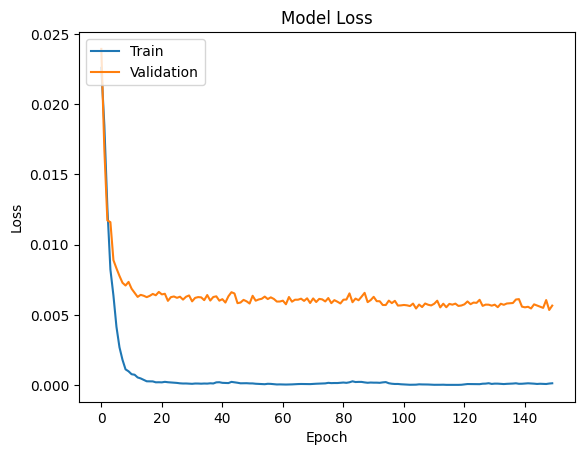

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [ ]:
model.save('./object_detection_vgg19.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning:

You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.



## VGG16

In [ ]:
vgg16 = VGG16(weights="imagenet", include_top=False, input_tensor=Input(shape=(224,224,3)))

# ---------------------
headmodel = vgg16.output
headmodel = Flatten()(headmodel)
headmodel = Dense(500, activation="relu")(headmodel)
headmodel = Dense(250, activation="relu")(headmodel)
headmodel = Dense(4, activation='sigmoid')(headmodel)

# ---------- model
model = Model(inputs=vgg16.input, outputs=headmodel)

58889256/58889256 [==============================] - 0s 0us/step


In [ ]:
# Compile model
model.compile(loss='mse',metrics='accuracy', optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4))
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0   

In [ ]:
tfb = TensorBoard('object_detection')
history = model.fit(x=x_train, y=y_train, batch_size=10, epochs=150,
                    validation_data=(x_test, y_test), callbacks=[tfb])

Epoch 1/150
18/18 [==============================] - 10s 189ms/step - loss: 0.0259 - accuracy: 0.5611 - val_loss: 0.0220 - val_accuracy: 0.6889
Epoch 2/150
18/18 [==============================] - 3s 170ms/step - loss: 0.0151 - accuracy: 0.7500 - val_loss: 0.0105 - val_accuracy: 0.8889
Epoch 3/150
18/18 [==============================] - 3s 174ms/step - loss: 0.0073 - accuracy: 0.8056 - val_loss: 0.0087 - val_accuracy: 0.9333
Epoch 4/150
18/18 [==============================] - 3s 172ms/step - loss: 0.0041 - accuracy: 0.8278 - val_loss: 0.0084 - val_accuracy: 0.7111
Epoch 5/150
18/18 [==============================] - 3s 172ms/step - loss: 0.0020 - accuracy: 0.8944 - val_loss: 0.0059 - val_accuracy: 0.9333
Epoch 6/150
18/18 [==============================] - 3s 175ms/step - loss: 0.0011 - accuracy: 0.9389 - val_loss: 0.0062 - val_accuracy: 0.9556
Epoch 7/150
18/18 [==============================] - 3s 176ms/step - loss: 6.0145e-04 - accuracy: 0.9611 - val_loss: 0.0053 - val_accuracy: 0

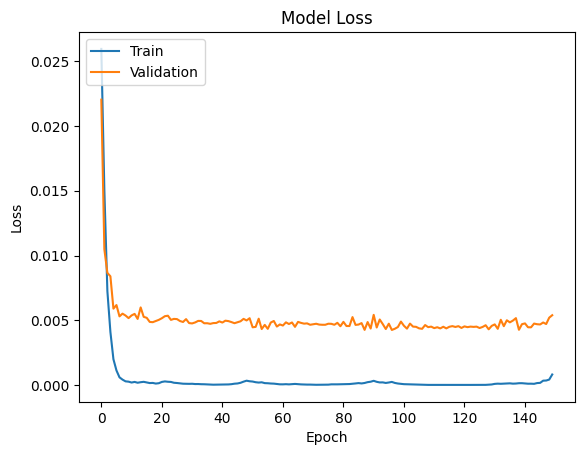

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [ ]:
model.save('./object_detection_vgg16.h5')

In [ ]:
# Load model
model = tf.keras.models.load_model('/content/drive/MyDrive/Dataset/object_detection_vgg16_jadi.h5')
print('Model loaded Sucessfully')

Model loaded Sucessfully


In [ ]:
path = '/content/image3.jpg'
image = load_img(path) # PIL object
image = np.array(image,dtype=np.uint8) # 8 bit array (0,255)
image1 = load_img(path,target_size=(224,224))
image_arr_224 = img_to_array(image1)/255.0  # Convert into array and get the normalized output

# Size of the orginal image
h,w,d = image.shape
print('Height of the image =',h)
print('Width of the image =',w)

Height of the image = 591
Width of the image = 1280


In [ ]:
fig = px.imshow(image)
fig.update_layout(width=700, height=500,  margin=dict(l=10, r=10, b=10, t=10), xaxis_title='Figure 13 - TEST Image')

In [ ]:
image_arr_224.shape

(224, 224, 3)

In [ ]:
test_arr = image_arr_224.reshape(1,224,224,3)
test_arr.shape

(1, 224, 224, 3)

In [ ]:
# Make predictions
coords = model.predict(test_arr)
coords

1/1 [==============================] - 0s 19ms/step


array([[0.31161115, 0.45790043, 0.47268173, 0.5767644 ]], dtype=float32)

In [ ]:
# Denormalize the values
denorm = np.array([w,w,h,h])
coords = coords * denorm
coords

array([[398.86226654, 586.11255646, 279.35490301, 340.86776322]])

In [ ]:
coords = coords.astype(np.int32)
coords

array([[398, 586, 279, 340]], dtype=int32)

In [ ]:
# Draw bounding on top the image
xmin, xmax,ymin,ymax = coords[0]
pt1 =(xmin,ymin)
pt2 =(xmax,ymax)
print(pt1, pt2)

(545, 275) (692, 333)


In [ ]:
cv2.rectangle(image,pt1,pt2,(0,255,0),3)
fig = px.imshow(image)
fig.update_layout(width=700, height=500, margin=dict(l=10, r=10, b=10, t=10))

In [ ]:
# Create pipeline
path = '/content/image3.jpg'
def object_detection(path):

    # Read image
    image = load_img(path) # PIL object
    image = np.array(image,dtype=np.uint8) # 8 bit array (0,255)
    image1 = load_img(path,target_size=(224,224))

    # Data preprocessing
    image_arr_224 = img_to_array(image1)/255.0 # Convert to array & normalized
    h,w,d = image.shape
    test_arr = image_arr_224.reshape(1,224,224,3)

    # Make predictions
    coords = model.predict(test_arr)

    # Denormalize the values
    denorm = np.array([w,w,h,h])
    coords = coords * denorm
    coords = coords.astype(np.int32)

    # Draw bounding on top the image
    xmin, xmax,ymin,ymax = coords[0]
    pt1 =(xmin,ymin)
    pt2 =(xmax,ymax)
    print(pt1, pt2)
    cv2.rectangle(image,pt1,pt2,(0,255,0),3)
    return image, coords

image, cods = object_detection(path)

fig = px.imshow(image)
fig.update_layout(width=700, height=500, margin=dict(l=10, r=10, b=10, t=10),xaxis_title='Figure 14')

1/1 [==============================] - 0s 29ms/step
(545, 275) (692, 333)


In [ ]:
!pip install pytesseract

In [ ]:
!sudo apt install tesseract-ocr

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  tesseract-ocr-eng tesseract-ocr-osd
The following NEW packages will be installed:
  tesseract-ocr tesseract-ocr-eng tesseract-ocr-osd
0 upgraded, 3 newly installed, 0 to remove and 18 not upgraded.
Need to get 4,816 kB of archives.
After this operation, 15.6 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/universe amd64 tesseract-ocr-eng all 1:4.00~git30-7274cfa-1.1 [1,591 kB]
Get:2 http://archive.ubuntu.com/ubuntu jammy/universe amd64 tesseract-ocr-osd all 1:4.00~git30-7274cfa-1.1 [2,990 kB]
Get:3 http://archive.ubuntu.com/ubuntu jammy/universe amd64 tesseract-ocr amd64 4.1.1-2.1build1 [236 kB]
Fetched 4,816 kB in 1s (3,386 kB/s)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debc

In [ ]:
import pytesseract as pt
from PIL import Image

# Tesseract path
pt.pytesseract.tesseract_cmd = r'/usr/bin/tesseract'


In [ ]:
img = np.array(load_img(path))
xmin ,xmax,ymin,ymax = cods[0]
roi = img[ymin:ymax,xmin:xmax]
fig = px.imshow(roi)
fig.update_layout(width=350, height=250, margin=dict(l=10, r=10, b=10, t=10),xaxis_title='Figure 15 Cropped image')

In [ ]:
# extract text from image
text = pt.image_to_string(roi)
print(text)

In [ ]:
import math

# Step 1: Membaca Input
a, m = map(float, input().split())
W, H, X, Y = map(int, input().split())

height_data = []
for _ in range(H):
    row = list(map(int, input().split()))
    height_data.append(row)

# Step 2: Mendefinisikan Fungsi Pasang Surut
def get_tide_level(t):
    return 0.5 * a * (math.cos(t * (2 * math.pi / 12)) + 1)

# Step 3: Mendefinisikan Fungsi Aksesibilitas Area
def can_access(z1, z2):
    return abs(z1 - z2) <= 10

# Step 4-7: Iterasi, Menghitung, dan Mencari Jarak Maksimum
max_distance = 0

for i in range(H):
    for j in range(W):
        z1 = height_data[Y][X]
        z2 = height_data[i][j]

        if can_access(z1, z2):
            distance = math.sqrt((i - Y)**2 + (j - X)**2)
            max_distance = max(max_distance, distance)

# Step 7: Output Jarak Maksimum
print(f"{max_distance * m:.8f}")


2.0 10.0  3 3 0 0  2001 1000 100  1001 10000 200  100 0 0


ValueError: ignored